---
date: last-modified
---

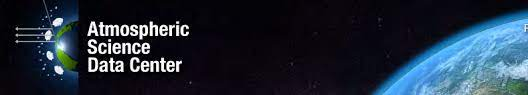\


# How to Access DSCOVR_EPIC_L2_TO3 Data using OPeNDAP with Python3 and Calculate Daily Statistics from Instantaneous Data

## Summary

This notebook demonstrates how to remotely access the Deep Space Climate Observatory (DSCOVR, [1]) Earth Polychromatic Imaging Camera (EPIC, [2]) L2 instantaneous total ozone column data [3] files via the Open-source Project for a Network Data Access Protocol (OPeNDAP), and then analyze the data by resampling instantaneous data into daily averages. We use DSCOVR_EPIC_L2_TO3_03 total ozone column product in this example. This collection is instantaneous total O3 column retrieval over entire Earth disk, 2048 lines by 2048 pixels, in each file (~165 MB per file, normally 16 - 18 files per day).

## Prerequisites

- This example code is written in Python3 (v3.9.2) Jupyter Notebook and requires these libraries: earthaccess, cartopy.crs (0.18.0), calendar, time, platform (make sure all packages are up to date). In particular, here is the instruction on how to install [cartopy](https://scitools.org.uk/cartopy/docs/v0.15/installing.html) and [earthaccess](https://earthaccess.readthedocs.io/en/latest/).
- You can execute this example code in your Jupyter Notebook. This code has been tested with Jupyter Notebook v6.2.0 and v6.3.0 in Mac OS, Jupyter Notebook v6.1.4 in Windows OS. Or you can just run it in your Python 3 enviroment. This code has been tested in Python 3 in Mac, window and Linux OS.

## Caveats

- Reading multiple hourly data files is a resource demanding task due to large data volume. It may take about 5 minutes to open one-month of the sample data (or longer if the data archive system is  currently heavily loaded). Be patient!
- Visualizing the figures may also take time (~4 minute)
- You may want to test first if your xarray package can read the data in your local disk before reading the data remotely as demonstrated in this case.

## Procedure

1. Register Earthdata account and set up the credential environment

2. Execute the Python code below in your Jupyter Notebook step-by-step
    1. Import the required Python modules or libraries. If any of the following import commands fail, check the local Python environment and install any missing packages.

<!-- You can run this tutorial in your browser using Colab:<br>

<a target="_blank" href="https://colab.research.google.com/github/OPENDAP/NASA-tutorials/blob/main/tutorials/daac-tutorials/How_to_Access_MERRA2_Using_OPeNDAP_with_Python3_Calculate_Weekly_from_Hourly.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a> -->


## References:
1. https://www.nesdis.noaa.gov/current-satellite-missions/currently-flying/dscovr-deep-space-climate-observatory
2. https://epic.gsfc.nasa.gov/about/epic
3. https://epic.gsfc.nasa.gov/science/products/o3

### Notebook Author / Affiliation
Alexander Radkevich / Atmospheric Science Data Center

## 1. Setup

In [ ]:
# # execution of this line may or may not be needed depending on availability of the library in the user's system
# ! pip3 install netCDF4

In [ ]:
# # execution of this line may or may not be needed depending on availability of the library in the user's system
# ! pip3 install shapely==1.7.1 cartopy earthaccess

**Import Authentication Libraries**

In [ ]:
import sys
import platform
import requests
import warnings

import earthaccess
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

print("platform.python_version() ", platform.python_version())
warnings.filterwarnings("ignore")

# from calendar import monthrange

**Create EDL files using the `earthaccess`**

First, pass your Earthdata credentials to the `earthaccess` library to create the `.netrc` file:

In [2]:
auth = earthaccess.login(strategy="interactive", persist=True)

Run the following code to generate the `.dodsrc` file, if it is not already present

In [3]:
# homeDir = os.path.expanduser("~") + os.sep

# with open(homeDir + '.dodsrc', 'w') as file:
#     file.write('HTTP.COOKIEJAR={}.urs_cookies\n'.format(homeDir))
#     file.write('HTTP.NETRC={}.netrc'.format(homeDir))
#     file.close()

# print('Saved .dodsrc to:', homeDir)

# # Set appropriate permissions for Linux/macOS
# if platform.system() != "Windows":
#     Popen('chmod og-rw ~/.netrc', shell=True)
# else:
#     # Copy dodsrc to working directory in Windows
#     shutil.copy2(homeDir + '.dodsrc', os.getcwd())
#     print('Copied .dodsrc to:', os.getcwd())

Saved .dodsrc to: /home/jovyan/


**Import the rest of the packages:**

In [11]:
# # ----------------------
# # Import Python modules
# # ----------------------
# import warnings
# warnings.filterwarnings("ignore")

# import numpy as np
# import netCDF4 as nc
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature

# #from calendar import monthrange
# import time
# import platform
# print("platform.python_version() ", platform.python_version())
# import requests

platform.python_version()  3.10.14


## 2. Accessing, exploring, and gridding data

### 2.1 Remotely access the instantaneous DSCOVR_EPIC_L2_TO3 files through OPeNDAP [URL](https://opendap.larc.nasa.gov/opendap/).

The user needs to choose year, month and range of days within the month, then the lists of available files are created for every day of interest.

Please note that the version of the collection may change. Current version is 3, see product_version  = '03'. In order to check for the current version, please search [EarthData](https://search.earthdata.nasa.gov/search?q=DSCOVR_EPIC_L2_TO3).

The line of "%%time" at the beginning of each cell is used for estimating the running time for that cell.

In [ ]:
%%time

sat_name = "DSCOVR"
sensor_name = "EPIC"
level = "L2"
product = "TO3"
product_version = "03"

year = int(input("Enter year of interest, within the range 2015 - 2023: "))
month = int(input("Enter month of interest, in the range 1 - 12: "))
firstday = int(input("Enter the 1st day of interest: "))
lastday = int(input("Enter the last day of interest: "))

if lastday < firstday:
    sys.exit()

nd = lastday - firstday + 1
days = np.array(range(firstday, lastday + 1), dtype=int)
daily_granule_list = np.empty(nd, dtype=object)
for i in range(nd):
    daily_granule_list[i] = np.empty(0, dtype=str)

# OPeNDAP URL
url = "https://opendap.larc.nasa.gov/opendap/{}/{}/{}_{}_{}/{:0>4d}/{:0>2d}/".format(
    sat_name, sensor_name, level, product, product_version, year, month
)
response = requests.get(url)
page = response.text

strings = page.split("\n")

granule_list = []
for s in strings:
    # searching for file links
    qq = s.find('"sameAs": "')
    if qq < 0:
        continue
    qh5 = s.find(".h5")
    if qh5 >= 0:
        qp = s.rfind('"')
        fname = s[qq + 11 : qp]
        # now check whether day is in the range on interest
        day = int(s[qh5 - 11 : qh5 - 9])
        if day < firstday or day > lastday:
            continue
        granule_list.append(s[qq + 11 : qh5 + 3])

        for i in range(nd):
            if day == days[i]:
                daily_granule_list[i] = np.append(daily_granule_list[i], s[qq + 11 : qh5 + 3])
                break

for i in range(nd):
    print("day", i + 1, ":", year, month, days[i], ", ", len(daily_granule_list[i]), " granules:")
    for granule in daily_granule_list[i]:
        print(granule)

### 2.2 Exploring DSCOVR_EPIC_L2_TO3_03 datasets and their dimensions.

In [6]:
ncf = nc.Dataset(granule_list[0], diskless=True, persist=False)

print("file " + granule_list[0] + " has been opened")
# print(ncf)
print(ncf.variables.keys())
print(ncf.dimensions.keys())
for d in ncf.dimensions.items():
    print(d)
for var in ncf.variables.items():
    print(var)

ncf.close()

file https://opendap.larc.nasa.gov/opendap/hyrax/DSCOVR/EPIC/L2_TO3_03/2023/06/DSCOVR_EPIC_L2_TO3_03_20230601000831_03.h5 has been opened
dict_keys(['AlgorithmFlag', 'CalibrationCoef', 'CloudPressure', 'ColumnWeightFunctionPercent', 'ControlFileContents', 'DNDomega', 'DNDreflectivity', 'ErrorFlag', 'ErythemalUV', 'LERTerrPres', 'NValue', 'NoABandCloud', 'NvalueAdjust', 'Ozone', 'OzoneStep1', 'RadiativeCloudFraction', 'RamanCorrection', 'Reflectivity', 'Residual', 'SatelliteAzimuthAngle', 'SatelliteZenithAngle', 'SlopeOfReflectivity', 'SolarAzimuthAngle', 'SolarZenithAngle', 'TerrainPressure', 'Wavelength', 'YearDaySeconds', 'Latitude', 'Longitude', 'FakeDim1', 'FakeDim3', 'FakeDim4', 'FakeDim5', 'FakeDim6', 'FakeDim7'])
dict_keys(['FakeDim0', 'FakeDim1', 'FakeDim2', 'FakeDim3', 'FakeDim4', 'FakeDim5', 'FakeDim6', 'FakeDim7', 'maxStrlen64'])
('FakeDim0', <class 'netCDF4._netCDF4.Dimension'>: name = 'FakeDim0', size = 2048)
('FakeDim1', <class 'netCDF4._netCDF4.Dimension'>: name = 'FakeD

### 2.3 Exploring ozone column and coordinates arrays

Reading total ozone column along with latitude/longitude positions from the first available granule.

Print the values in the center and in the corner to see actual fill values.
As we have seen, fill value attributes are not set up. Due to the nature of the data, values in the corner, [0, 0], are fill values.

In [7]:
# ---------------------------------------------------
# Select variable of interest
# ---------------------------------------------------
o3_var_name = "Ozone"
lat_var_name = "Latitude"
lon_var_name = "Longitude"

# open the same granule file and read variables listed above
ncf = nc.Dataset(granule_list[0], diskless=True, persist=False)

o3 = np.array(ncf.variables[o3_var_name])
lat = np.array(ncf.variables[lat_var_name])
lon = np.array(ncf.variables[lon_var_name])

nx = ncf.dimensions["FakeDim0"].size
print(nx)
ny = ncf.dimensions["FakeDim2"].size
print(ny)

# close access to the granule file
ncf.close()

nx_c = nx // 2
ny_c = ny // 2
print("latitude of the center of the granule:", lat[nx_c, ny_c])
print("longitude of the center of the granule:", lon[nx_c, ny_c])
print("ozone column fill value:", o3[nx_c, ny_c])

fv_o3 = o3[0, 0]  # ozone fill value
fv_lat = lat[0, 0]  # latitude fill value
fv_lon = lon[0, 0]  # longitude fill value

print("ozone column fill value:", fv_o3)
print("latitude fill value:", fv_lat)
print("longitude fill value:", fv_lon)
mask = (o3 > 0.0) & (lat != fv_lat) & (lon != fv_lon)
o3_loc = o3[mask].flatten()
print("number of valid pixels in the image", len(o3_loc))

2048
2048
latitude of the center of the granule: 21.796875
longitude of the center of the granule: 168.77197
ozone column fill value: 304.74655
ozone column fill value: -999.0
latitude fill value: inf
longitude fill value: inf
number of valid pixels in the image 1835199


### 2.4 Enter description of the output grid.

User needs to select geographic box of interest along with the steps of the grid. The code asks for three parameters for both latitude and longitude:

`lat_l`, `lat_u`, and `lat_delta`: lower and upper latitudes and step;

`lon_l`, `lon_u`, and `lon_delta`: lower and upper longitudes and step.

The centers of the gridboxes are computed as follow:

$nlat = int((lat_{u} - lat_{l})/lat_{delta})$,

$nlon = int((lon_{u} - lon_{l})/lon_{delta})$,

$lat = lat_{l} + lat_{delta}*(ilat + 0.5), ilat = 0, 1, ..., nlat - 1$,

$lon = lon_{l} + lon_{delta}*(ilon + 0.5), ilon = 0, 1, ..., nlon - 1$.

Please be aware that the grid is step-driven, i.e. actual grid extent can be less than `lat_u` and `lon_u`, while `lat_u` and `lon_u` are preserved.
For example, if user chose `lat_l = 10`, `lat_u = 15`, `lat_delta = 0.4`
`nlat = int(5/.4) = 12` and the latitude of the center of the last gridbox is `10 + 0.4*(11 + .5) = 14.6` and its North extent is 14.8.

The user is asked to confirm chosen grid.

Example below is to show the impact of Canadian wildfires of 2023 to the US NorthEast. To do this, select the following spatial extent:
Southmost latitude: 35
Northmost latitude: 65
latitude step: .25
Westmost longitude: -90
Easthmost longitude: -65
longitude step: .2

In [8]:
confirmation = ""
while confirmation != "Y":
    lat_l = float(input("Enter the Southmost latitude: "))
    lat_u = float(input("Enter the Northmost latitude: "))
    lat_delta = float(input("Enter the latitude step: "))

    lon_l = float(input("Enter the Westmost longitude: "))
    lon_u = float(input("Enter the Easthmost longitude: "))
    lon_delta = float(input("Enter the longitude step: "))

    nlat = int((lat_u - lat_l) / lat_delta)
    nlon = int((lon_u - lon_l) / lon_delta)

    lat_min = lat_l
    lat_max = lat_l + lat_delta * nlat
    lon_min = lon_l
    lon_max = lon_l + lon_delta * nlon

    print("latitude extent ", lat_min, lat_max, "latitude step ", lat_delta)
    print("longitude extent ", lon_min, lon_max, "longitude step ", lon_delta)
    confirmation = input(
        'Please confirm your choice of the grid, Y for "yes", any character for "no": '
    )

Enter the Southmost latitude:  35
Enter the Northmost latitude:  65
Enter the latitude step:  .25
Enter the Westmost longitude:  -90
Enter the Easthmost longitude:  -65
Enter the longitude step:  .2


latitude extent  35.0 65.0 latitude step  0.25
longitude extent  -90.0 -65.0 longitude step  0.2


Please confirm your choice of the grid, Y for "yes", any character for "no":  Y


### 2.5 Gridding data to the selected grid

Though spatial sub-setting of L2 product cannot be done in OPENDAP, it can be done before gridding and averaging data. This is done by adding extra conditions on latitudes and longitudes besides removing fill values.

In [9]:
# create output array
avg_O3 = np.zeros([nd, nlat, nlon], dtype=float)
cnt_O3 = np.zeros([nd, nlat, nlon], dtype=int)
for i in range(nd):
    for granule in daily_granule_list[i]:
        ncf = nc.Dataset(granule, diskless=True, persist=False)

        o3 = np.array(ncf.variables[o3_var_name]).flatten()
        lat = np.array(ncf.variables[lat_var_name]).flatten()
        lon = np.array(ncf.variables[lon_var_name]).flatten()
        ncf.close()

        mask = (
            (o3 > 0.0)
            & (lat != fv_lat)
            & (lon != fv_lon)
            & (lat > lat_min)
            & (lat < lat_max)
            & (lon > lon_min)
            & (lon < lon_max)
        )

        o3_m = o3[mask]
        lat_m = lat[mask]
        lon_m = lon[mask]
        nmask = len(o3_m)
        for imask in range(nmask):
            ilat = int((lat_m[imask] - lat_min) / lat_delta)
            ilon = int((lon_m[imask] - lon_min) / lon_delta)
            avg_O3[i, ilat, ilon] = avg_O3[i, ilat, ilon] + o3_m[imask]
            cnt_O3[i, ilat, ilon] = cnt_O3[i, ilat, ilon] + 1

        print(granule)  # this print is added to control the progress, it can be painlessly removed

mask_all = cnt_O3[i, ilat, ilon] > 0
avg_O3[mask_all] = avg_O3[mask_all] / cnt_O3[mask_all]

https://opendap.larc.nasa.gov/opendap/hyrax/DSCOVR/EPIC/L2_TO3_03/2023/06/DSCOVR_EPIC_L2_TO3_03_20230601000831_03.h5
https://opendap.larc.nasa.gov/opendap/hyrax/DSCOVR/EPIC/L2_TO3_03/2023/06/DSCOVR_EPIC_L2_TO3_03_20230601011358_03.h5
https://opendap.larc.nasa.gov/opendap/hyrax/DSCOVR/EPIC/L2_TO3_03/2023/06/DSCOVR_EPIC_L2_TO3_03_20230601064113_03.h5
https://opendap.larc.nasa.gov/opendap/hyrax/DSCOVR/EPIC/L2_TO3_03/2023/06/DSCOVR_EPIC_L2_TO3_03_20230601074640_03.h5
https://opendap.larc.nasa.gov/opendap/hyrax/DSCOVR/EPIC/L2_TO3_03/2023/06/DSCOVR_EPIC_L2_TO3_03_20230601085208_03.h5
https://opendap.larc.nasa.gov/opendap/hyrax/DSCOVR/EPIC/L2_TO3_03/2023/06/DSCOVR_EPIC_L2_TO3_03_20230601095735_03.h5
https://opendap.larc.nasa.gov/opendap/hyrax/DSCOVR/EPIC/L2_TO3_03/2023/06/DSCOVR_EPIC_L2_TO3_03_20230601110302_03.h5
https://opendap.larc.nasa.gov/opendap/hyrax/DSCOVR/EPIC/L2_TO3_03/2023/06/DSCOVR_EPIC_L2_TO3_03_20230601120830_03.h5
https://opendap.larc.nasa.gov/opendap/hyrax/DSCOVR/EPIC/L2_TO3_0

## 3. Plotting maps of daily average O3 columns

In [ ]:
%%time
lon = lon_min + lon_delta * (np.arange(nlon) + 0.5)
lon_all = np.empty([nlat, nlon])
for ilat in range(nlat):
    lon_all[ilat, :] = lon[:]

lat = lat_min + lat_delta * (np.arange(nlat) + 0.5)
lat_all = np.empty([nlat, nlon])
for ilon in range(nlon):
    lat_all[:, ilon] = lat[:]

for i in range(nd):
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(resolution="110m", color="black", linewidth=1)
    ax.add_feature(cfeature.LAKES.with_scale("110m"), facecolor="none", edgecolor="black")

    im = ax.scatter(
        lon_all,
        lat_all,
        c=avg_O3[i, :, :],
        s=1,
        cmap=plt.cm.jet,
        vmin=200.0,
        vmax=500.0,
        transform=ccrs.PlateCarree(),
    )
    cb = plt.colorbar(im, ticks=[200, 300, 400, 500, 600], fraction=0.022, pad=0.01)
    cb.set_label("DU", fontsize=10)
    ax.set_title("avg " + o3_var_name + str(" %4d %2.2d %2.2d" % (year, month, days[i])), size=10)

    plt.savefig(
        "avg_" + o3_var_name + str("_%4d_%2.2d_ %2.2d" % (year, month, days[i])) + ".png", dpi=600
    )
    plt.show()
    plt.close()